In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyod

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 2.1MB 7.9MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=6e0b262b4b4d121e5426e6e093abd63e5588da76417a1df57300fc1efc0c8aec
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=b0730b1aca2c488dcb9680ecc34317850f0d433a7aeaf772f93ab858a292e3b7
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=b6751c5a7fc9f995c119e549c20f872fa2f5f178c7f03a012a58bd37303afcab
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [3]:
!pip install suod 

In [146]:
%cd /content/drive/My\ Drive/TAA

/content/drive/My Drive/TAA


Bloc fonctions

In [0]:
from sklearn.svm import OneClassSVM
import time
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.hbos import HBOS
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix

In [0]:
from scipy import stats
import scipy.io

In [0]:
def upload_data(path):
  mat = scipy.io.loadmat(path)
  X, y = mat['X'], mat['y']
  y = y.astype(np.int64)
  y[y == 1] = -1
  y[y == 0] = 1
  return X,y

In [0]:
def plot_var_in_out(X,y,var1,var2,var3,var4):
  x1 = X[:,var1]
  x2 = X[:,var2]
  x3 = X[:,var3]
  x4 = X[:,var4]

  fig = plt.figure(figsize=(20,18))

  ax0 = fig.add_subplot(5,3,1)
  ax0.scatter(x1, x2, alpha=0.7, c=y)
  ax0.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var2))
  ax0.set_xlabel('variable '+str(var1)) 
  ax0.set_ylabel('variable '+str(var2)) 

  ax1 = fig.add_subplot(5,3,2)
  ax1.scatter(x1, x3, alpha=0.5,  c=y)
  ax1.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var3))
  ax1.set_xlabel('variable '+str(var1))
  ax1.set_ylabel('variable '+str(var3))

  ax2 = fig.add_subplot(5,3,3)
  ax2.scatter(x1, x4, alpha=0.5,  c=y)
  ax2.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var4))
  ax2.set_xlabel('variable '+str(var1))
  ax2.set_ylabel('variable '+str(var4))

  plt.tight_layout()
  plt.show()

In [0]:
def evaluation_detection(ytrue,ypred):

  var1 = 10
  var2 = 20

  ind_col = np.zeros(len(ytrue))
  ytrue = np.squeeze(np.asarray(ytrue))
  ind_col[(ytrue == -1)&(ypred == -1)] = 1
  ind_col[(ytrue == 1)&(ypred == -1)] = 2
  ind_col[(ytrue == -1)&(ypred == 1)] = 3

  classes = ['Inlier en test et en prediction','Outlier en test et en prediction','Inlier manqué par le modèle','Outlier manqué par le modèle']
  col = ['yellow','green','blue','red']

  fig = plt.figure(figsize=(14,18))

  ax0 = fig.add_subplot(5,2,1)
  data = confusion_matrix(ytrue, ypred)
  labels = ['Outlier', 'Inliers']
  sns.heatmap(data, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", ax=ax0) 
  ax0.set_title('Matrice de confusion')

  ax1 = fig.add_subplot(5,2,2)
  base = X_test[np.where(ind_col == 0)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[0], label = classes[0])
  base = X_test[np.where(ind_col == 1)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[1], label = classes[1])
  base = X_test[np.where(ind_col == 2)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[2], label = classes[2])
  base = X_test[np.where(ind_col == 3)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[3], label = classes[3])
  ax1.set_title('Représentation des données selon la différence entre le vrai label et la prévision')
  ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Catégorie")
  ax1.set_xlabel('x1') 
  ax1.set_ylabel('x2') 

  plt.tight_layout()
  plt.show()

In [0]:
def deep_predict(model,X_test):
  ypred = model.predict(X_test_scaled)
  mse = np.mean(np.power(X_test_scaled - ypred, 2), axis=1)
  df_error = pd.DataFrame({'reconstruction_error': mse})
  outliers = df_error.index[df_error.reconstruction_error > outlier_prop].tolist()
  y_pred = np.ones(len(y_test))
  y_pred[outliers] = -1
  return y_pred

In [0]:
def evaluate(ytrue,ypred):
  
    CM = confusion_matrix(ytrue, ypred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    metrics = pd.DataFrame([],columns=['accuracy','recall','True negative rate','False discovery rate'])
    metrics['accuracy'] = [accuracy_score(ytrue,ypred)]
    metrics['recall'] = [recall_score(ytrue,ypred,average='macro')]
    metrics['True negative rate'] = [FN/(TP+FN)]
    metrics['False discovery rate'] = [FP/(TP+FP)]

    return metrics

In [0]:
def split_data(split_method, X, y):
  mask = np.where(y == 1)[0][:int(len(y[y == 1])*0.80)]
  index = list(np.arange(len(y)))
  anti_mask = list(set(index).difference(set(mask)))
  if split_method == "anomalies":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  if split_method == "nouveautes":
    X_train, X_test, y_train, y_test = X[mask], X[anti_mask], y[mask], y[anti_mask]
  return X_train, X_test, y_train, y_test

def prepro_data(path,type_):
  X, y = upload_data(path)
  X_train, X_test, y_train, y_test = split_data(type_,X,y)
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

Analyse

In [0]:
X, y = upload_data('satimage-2.mat')

In [0]:
X_speech, y_speech = upload_data('speech.mat')

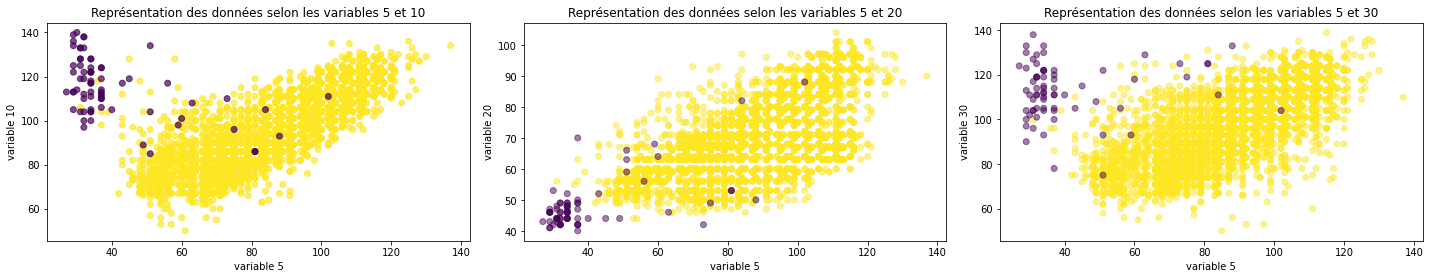

In [243]:
plot_var_in_out(X,y,5,10,20,30)

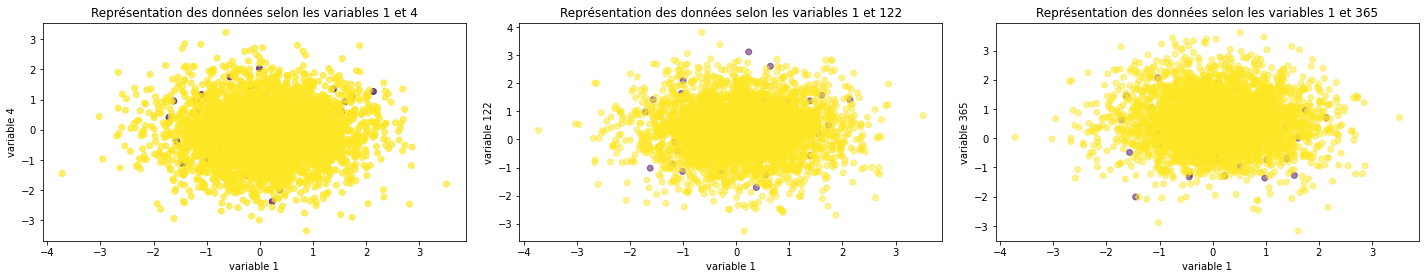

In [244]:
plot_var_in_out(X_speech,y_speech,1,4,122,365)

# Détection d'anomalies

Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('satimage-2.mat', 'anomalies')

In [250]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 36)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_56 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_59 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_60 (Dense)             (None, 36)                396

In [0]:
anomaly_algorithms = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.968987  0.780868            0.026499              0.004989


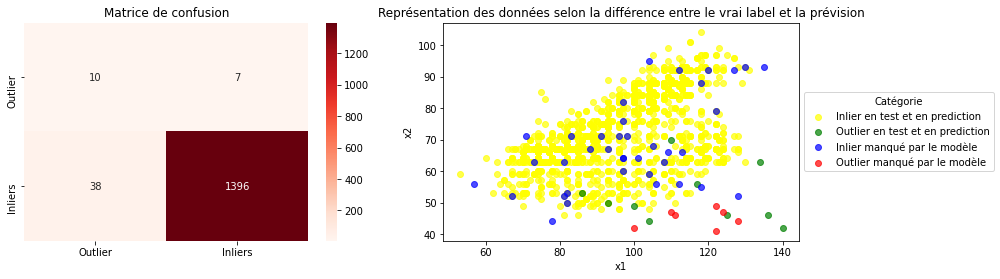

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.973811  0.841435            0.023013              0.003556


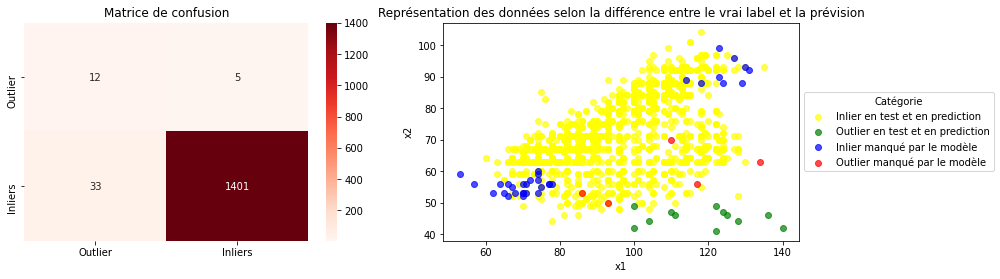

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.971744  0.869452            0.025802              0.002855


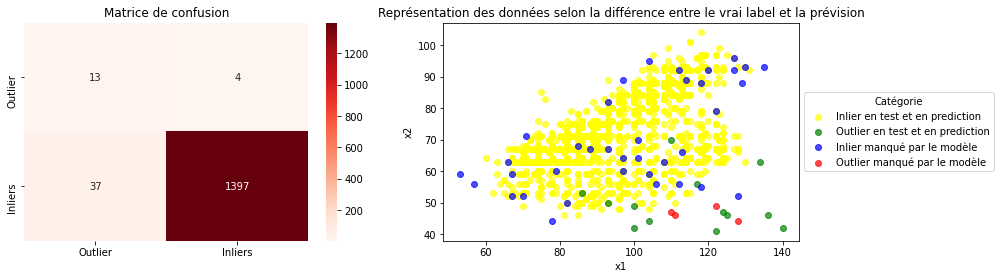

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978635  0.989191            0.021618                   0.0


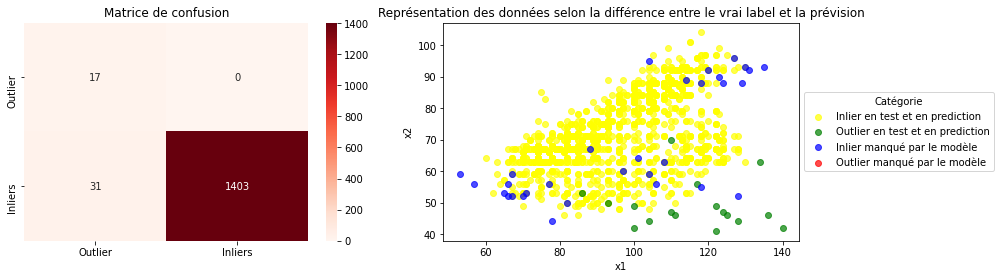

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.977257  0.988494            0.023013                   0.0


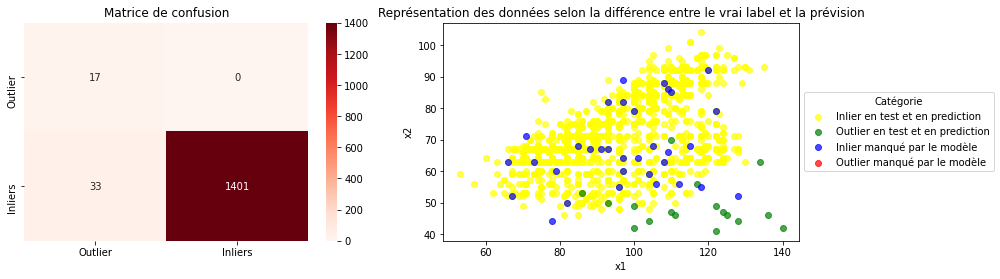

---------Deep MLP-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.987595  0.67403            0.004881               0.00765


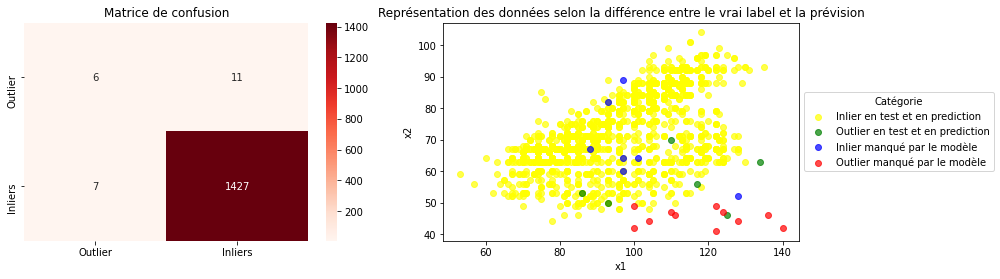

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.960717  0.544179            0.029289              0.010661


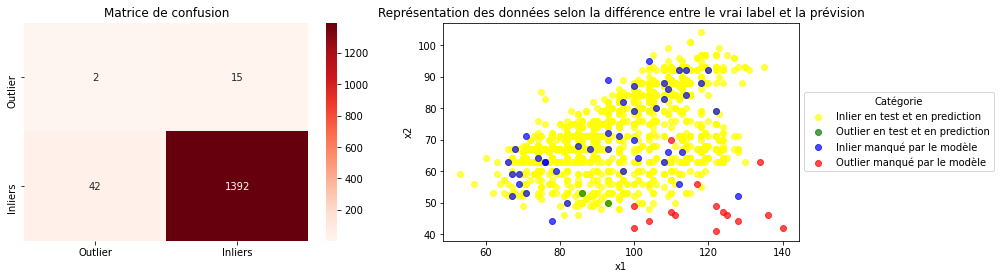

In [252]:
 for name, algorithm in anomaly_algorithms:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)

Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('speech.mat', 'anomalies')

In [254]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)                4010      
_________________________________________________________________
dense_62 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_65 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_66 (Dense)             (None, 400)               440

In [0]:
anomaly_algorithms = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.563997              0.0299              0.017937


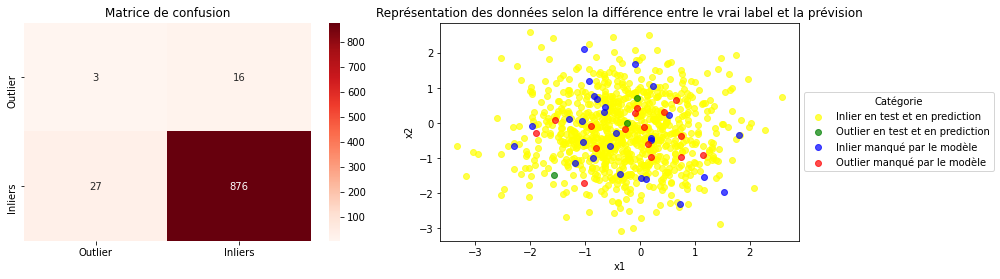

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.950108  0.510812            0.031008              0.020157


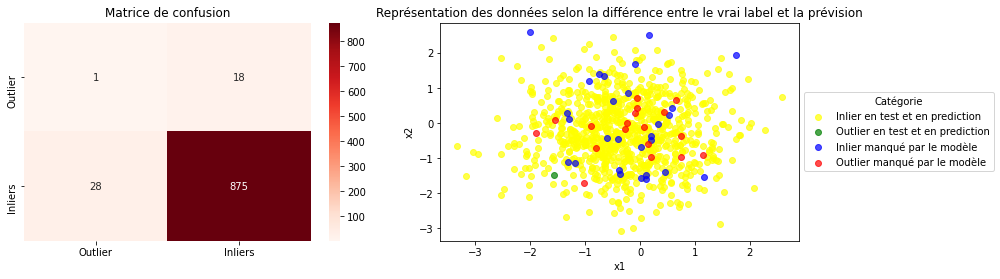

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.951193  0.537128            0.031008              0.019058


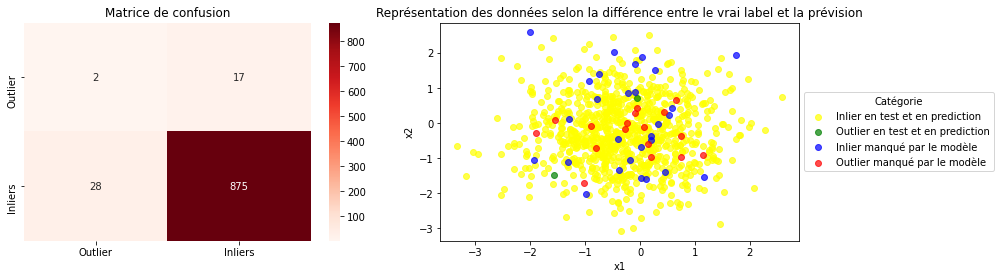

---------Isolation Forest-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


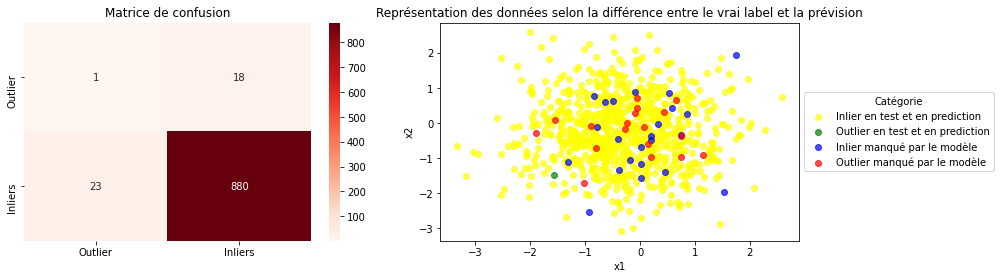

---------KNN-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


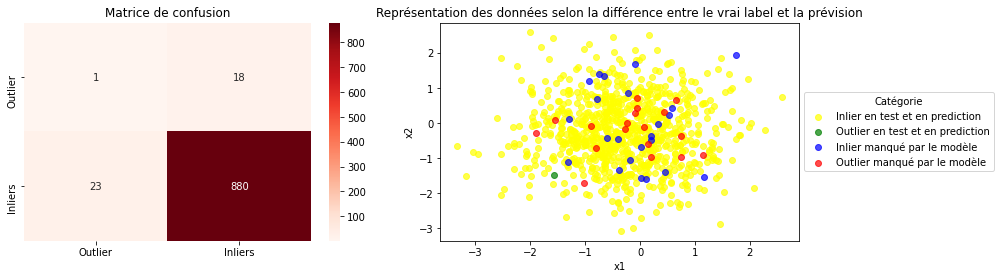

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.976139  0.498339            0.003322              0.020675


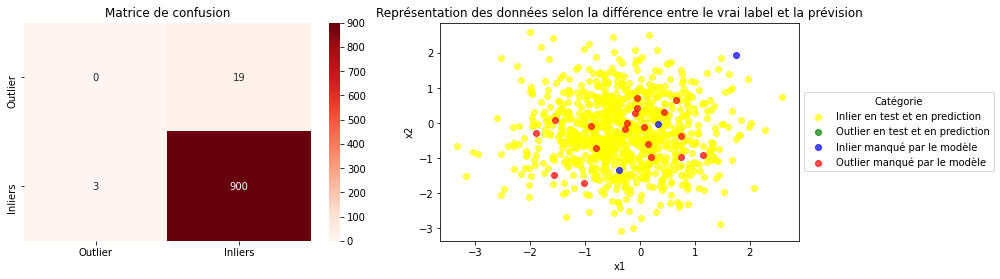

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.538235            0.028793              0.019016


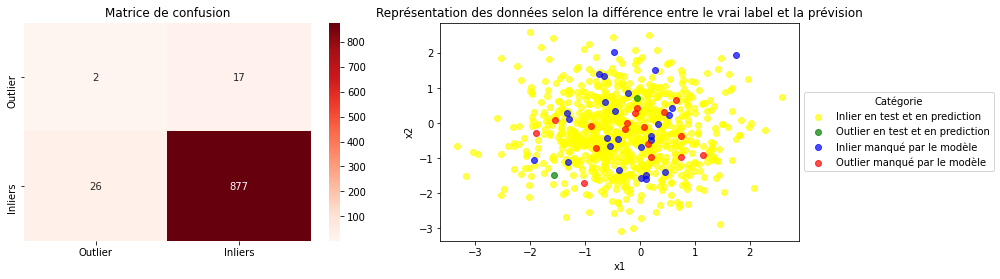

In [256]:
 for name, algorithm in anomaly_algorithms:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)

# Détection de nouveautés

Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('satimage-2.mat', 'nouveautes')

In [258]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 36)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_71 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_72 (Dense)             (None, 36)                396

In [0]:
novelty_algorithms = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.970443  0.977701            0.030514              0.000898


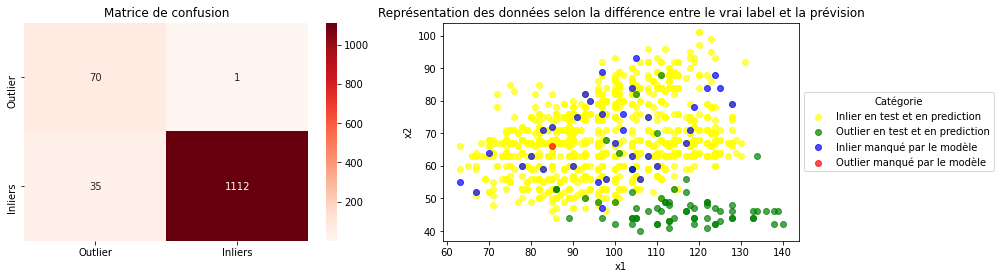

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.982759  0.918176            0.008718              0.009582


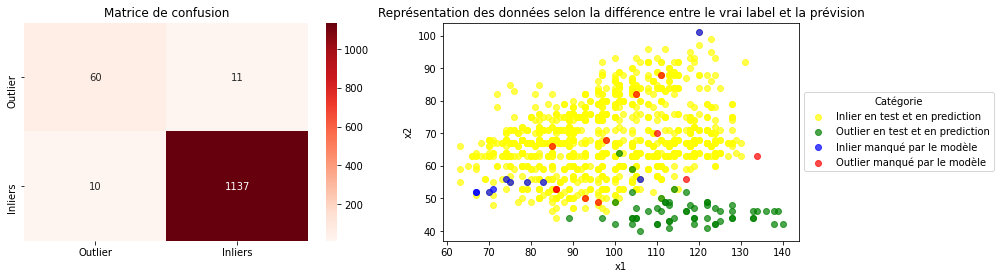

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.971966            0.027899              0.001791


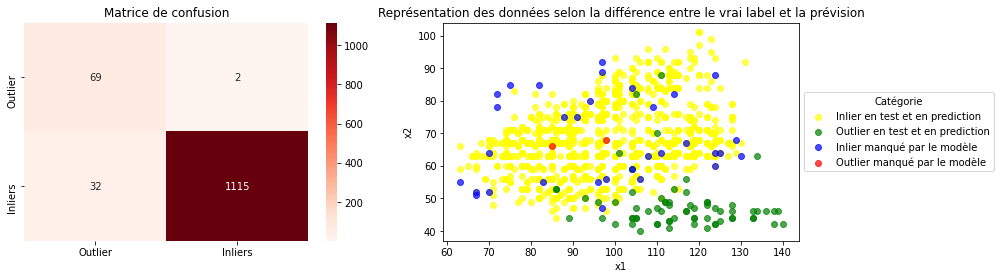

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.981117  0.976761            0.018309              0.001773


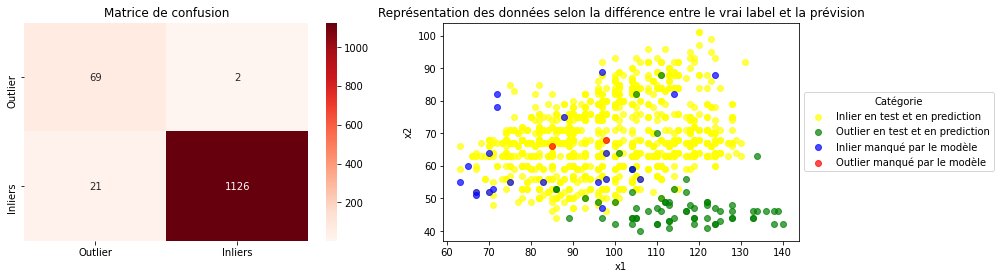

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.985179            0.029643                   0.0


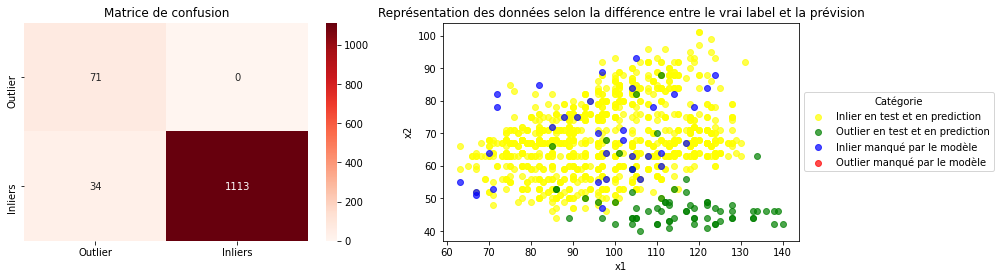

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.990969  0.981992            0.007847              0.001754


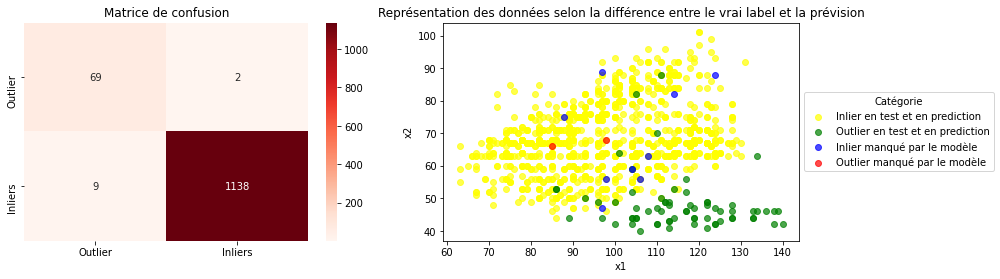

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.924466  0.543696            0.025283              0.053345


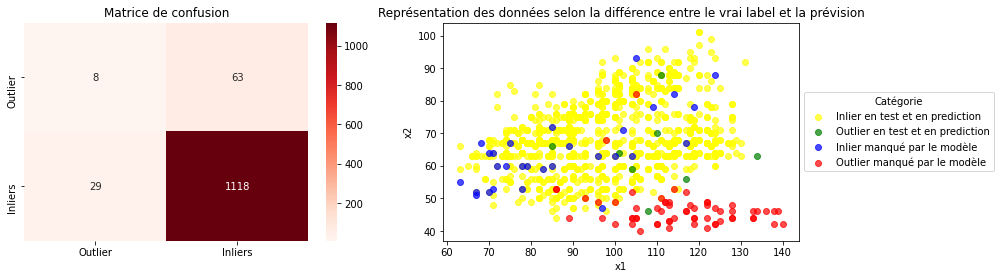

In [260]:
 for name, algorithm in novelty_algorithms:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
     

Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('speech.mat', 'nouveautes')

In [262]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                4010      
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_77 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_78 (Dense)             (None, 400)               440

In [0]:
novelty_algorithms = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.890585  0.550322            0.046897              0.069987


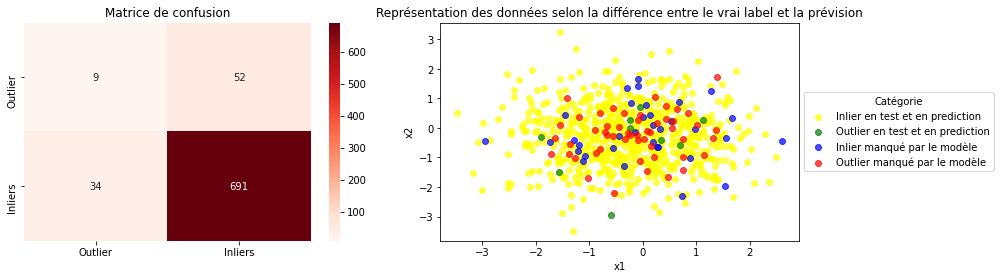

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.784987  0.463053            0.155862              0.083832


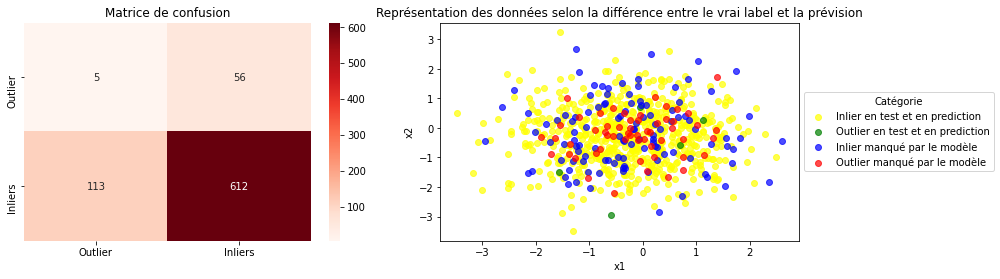

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.776081  0.465732            0.166897               0.08346


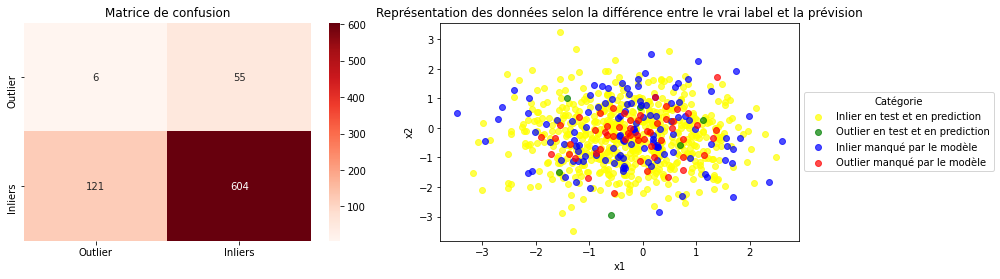

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.795165  0.476077            0.146207              0.081602


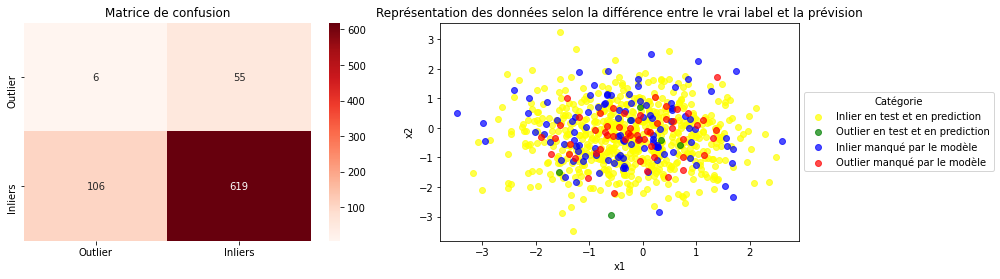

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0   0.78626  0.471249            0.155862              0.082459


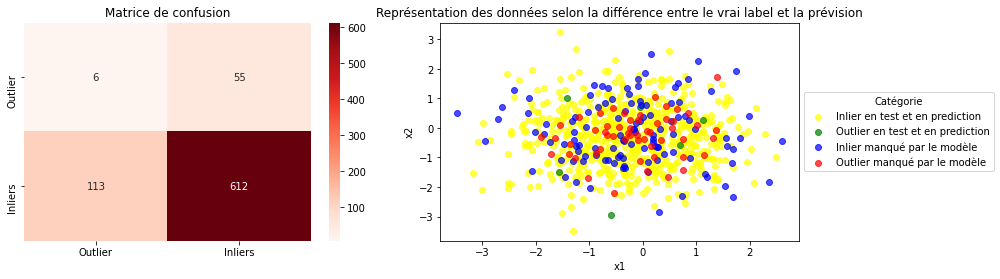

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.881679  0.485438            0.045517              0.079787


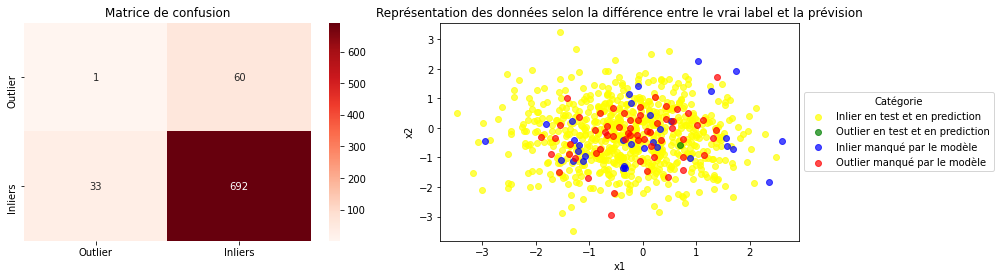

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.894402  0.492335            0.031724               0.07874


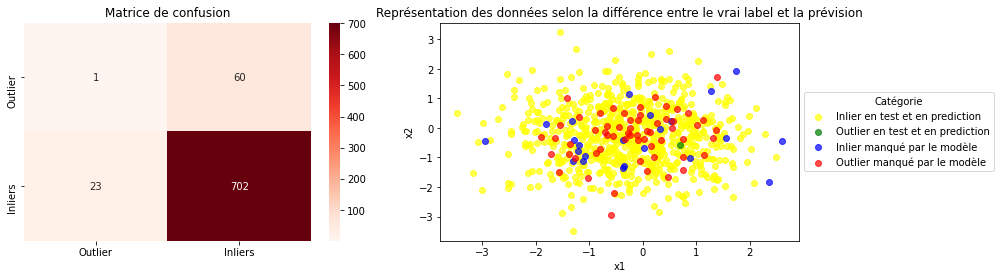

In [264]:
 for name, algorithm in novelty_algorithms:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(y_test,y_pred)
     